In this notebook, I will be exploring a dataset of 311 complaints in New York City, focusing on complaints related to syringe litter. I would like to investigate the factors driving syringe complaints.

In [1]:
# Import libraries
import geopandas as gpd
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split

In [ ]:
# Download all of the 311 complaints in 2022
# To limit the size of the download, select only unique_key, created_date, complaint_type, descriptor, longitude, and latitude
all_311_complaints = pd.read_csv('https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$query=SELECT%20unique_key,created_date,complaint_type,descriptor,longitude,latitude%20WHERE%20date_extract_y(created_date)IN(2022)%20LIMIT%2050000000')
all_311_complaints.head(2)

,unique_key,created_date,complaint_type,descriptor,longitude,latitude
0,54390926,2022-06-06T23:29:20.000,Illegal Parking,Blocked Hydrant,-73.839212,40.787189
1,54390783,2022-04-27T10:28:53.000,General Construction/Plumbing,Posted Notice Or Order Removed/Tampered With,-73.945160,40.617645


In [ ]:
# Rename 'created_date' to 'created_datetime', convert it to a datetime
# Extract date and month
all_311_complaints = all_311_complaints.rename(columns = {'created_date': 'created_datetime'})
all_311_complaints['created_datetime'] = pd.to_datetime(all_311_complaints['created_datetime'])
all_311_complaints['created_date'] = all_311_complaints['created_datetime'].dt.date
all_311_complaints['created_month'] = all_311_complaints['created_datetime'].dt.month

In [ ]:
# Keep only the rows that have latitude and longitude data
all_311_complaints = all_311_complaints[(pd.isna(all_311_complaints['longitude']) == False) & (pd.isna(all_311_complaints['latitude']) == False)]

In [ ]:
# Remove 'duplicate' reports, i.e., reports with the same date, complaint_type, descriptor, latitude, and longitude
all_311_complaints = all_311_complaints.drop_duplicates(subset = ['created_date', 'complaint_type', 'descriptor', 'latitude', 'longitude'])
all_311_complaints = all_311_complaints.reset_index(drop = True)

In [ ]:
# Turn all_311_complaints into a GeoDataFrame
all_311_complaints = gpd.GeoDataFrame(all_311_complaints, geometry = gpd.points_from_xy(all_311_complaints.longitude, all_311_complaints.latitude), crs = 'EPSG:4326')
all_311_complaints = all_311_complaints.to_crs(epsg=2263) # projection = NAD83 / New York Long Island

I had originally planned to analyze the complaints by city council district (CCD), but I decided to base my analysis on neighborhood tabulation area (NTA) instead because there are 5 times as many NTAs, and therefore more samples to train the model on.

In [ ]:
# Download the neighborhood tabulation area (NTA) data
!wget https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/neighborhood-tabulation-areas/nynta2020_25a.zip -O nta.zip
!unzip nta.zip

--2025-04-15 02:51:51--  https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/bytes/neighborhood-tabulation-areas/nynta2020_25a.zip
Resolving s-media.nyc.gov (s-media.nyc.gov)... 184.24.50.110, 2600:1409:3c00:b87::1500, 2600:1409:3c00:b83::1500
Connecting to s-media.nyc.gov (s-media.nyc.gov)|184.24.50.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 989198 (966K) [application/zip]
Saving to: ‘nta.zip’

nta.zip             100%[===================>] 966.01K  3.13MB/s    in 0.3s    

2025-04-15 02:51:53 (3.13 MB/s) - ‘nta.zip’ saved [989198/989198]

Archive:  nta.zip
  inflating: nynta2020_25a/nynta2020.shp  
  inflating: nynta2020_25a/nynta2020.dbf  
  inflating: nynta2020_25a/nynta2020.shx  
  inflating: nynta2020_25a/nynta2020.prj  
  inflating: nynta2020_25a/nynta2020.shp.xml  


In [ ]:
# Load the neighborhood tabulation area data
nta = gpd.read_file('/content/nynta2020_25a/nynta2020.shp')
nta = nta.to_crs(2263)
nta.head(2)

,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape_Leng,Shape_Area,geometry
0,3,Brooklyn,047,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28919.562151,3.532181e+07,"POLYGON ((1003059.997 204572.025, 1002991.367 ..."
1,3,Brooklyn,047,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.026805,2.885431e+07,"POLYGON ((995851.915 203199.332, 995969.192 20..."


In [ ]:
# Perform a spatial join to link each 311 complaint with a neighborhood tabulation area
all_311_complaints = gpd.sjoin(all_311_complaints, nta[['NTA2020', 'geometry']], how = 'left')

In [ ]:
all_311_complaints.head(2)

,unique_key,created_datetime,complaint_type,descriptor,longitude,latitude,created_date,created_month,geometry,index_right,NTA2020
0,54390926,2022-06-06 23:29:20,Illegal Parking,Blocked Hydrant,-73.839212,40.787189,2022-06-06,6,POINT (1028775 226112.014),185.0,QN0701
1,54390783,2022-04-27 10:28:53,General Construction/Plumbing,Posted Notice Or Order Removed/Tampered With,-73.945160,40.617645,2022-04-27,4,POINT (999475 164306.014),59.0,BK1801


In [ ]:
# For each complaint in all_311_complaints, test whether that complaint correlates with syringe complaints
for complaint in list(set(all_311_complaints['complaint_type'])):
  complaints_by_nta = all_311_complaints.groupby('NTA2020').agg(all_complaints = ('unique_key', 'count'),
                                                           syringe_complaints = ('descriptor', lambda x: (x == 'Syringes').sum()),
                                                           other_complaints = ('complaint_type', lambda x: (x == complaint).sum()))

  test_corr = stats.pearsonr(complaints_by_nta['syringe_complaints']/complaints_by_nta['all_complaints'],
                             complaints_by_nta['other_complaints']/complaints_by_nta['all_complaints'])
  if (test_corr[0] > 0.4) & (test_corr[1] < 0.01):
    print(complaint, test_corr)

Encampment PearsonRResult(statistic=np.float64(0.5114720329150472), pvalue=np.float64(1.143732495965466e-18))
Panhandling PearsonRResult(statistic=np.float64(0.42284913809933644), pvalue=np.float64(1.1737370051832548e-12))
Mold PearsonRResult(statistic=np.float64(0.4413333076335459), pvalue=np.float64(9.025424059750042e-14))


I will explore encampment complaints further, since those have the most correlation with syringe complaints.

In [ ]:
# Group all_311_complaints by NTA and calculate the number of all 311 complaints, the number of syringe complaints, and the number of encampment complaints for each one
complaints_nta = all_311_complaints.groupby('NTA2020').agg(all_complaints = ('unique_key', 'count'),
                                                           syringe_complaints = ('descriptor', lambda x: (x == 'Syringes').sum()),
                                                           encampment_complaints = ('complaint_type', lambda x: (x == 'Encampment').sum()))
complaints_nta = complaints_nta.reset_index()

In [ ]:
complaints_nta.describe()

,all_complaints,syringe_complaints,encampment_complaints
count,259.000000,259.000000,259.000000
mean,10071.351351,2.517375,108.656371
std,8075.424918,6.375423,247.746889
min,1.000000,0.000000,0.000000
25%,3414.000000,0.000000,4.000000
50%,9295.000000,0.000000,20.000000
75%,14597.500000,2.000000,84.500000
max,34749.000000,52.000000,2215.000000


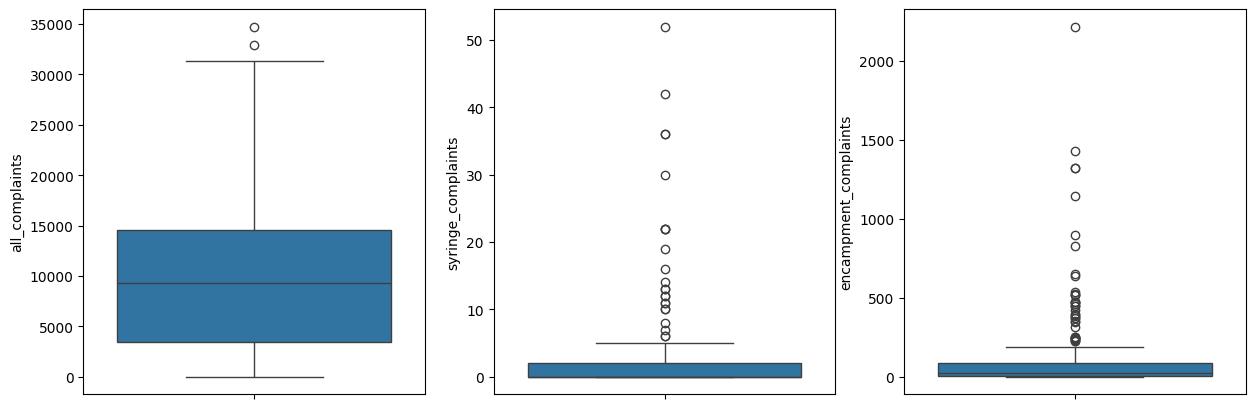

In [ ]:
# Make boxplots of all_complaints, syringe_complaints, and encampment_complaints to see whether there are any outliers
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
ax1 = sns.boxplot(data = complaints_nta, y = 'all_complaints', ax = ax1)
ax2 = sns.boxplot(data = complaints_nta, y = 'syringe_complaints', ax = ax2)
ax3 = sns.boxplot(data = complaints_nta, y = 'encampment_complaints', ax = ax3)

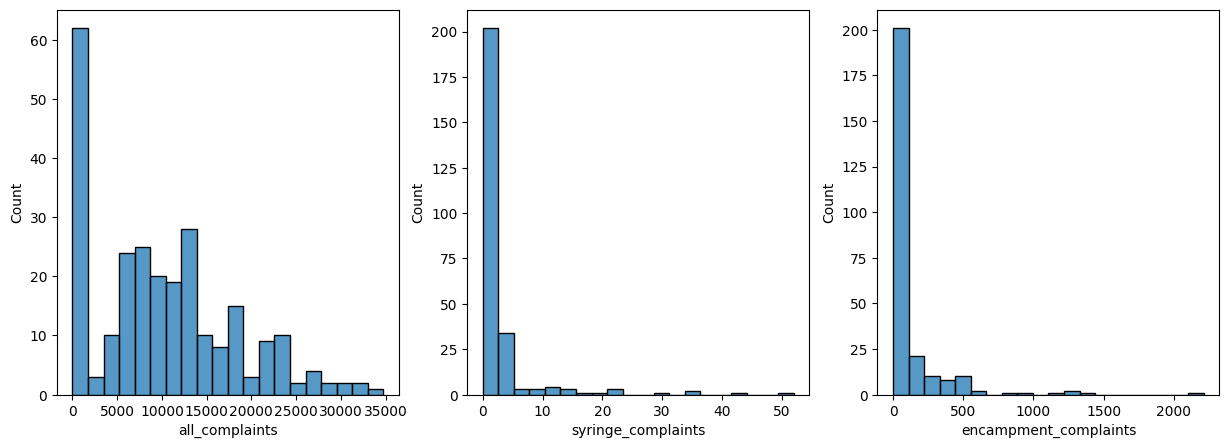

In [ ]:
# Make histplots of all_complaints, syringe_complaints, and encampment_complaints
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
ax1 = sns.histplot(data = complaints_nta, x = 'all_complaints', ax = ax1, bins = 20)
ax2 = sns.histplot(data = complaints_nta, x = 'syringe_complaints', ax = ax2, bins = 20)
ax3 = sns.histplot(data = complaints_nta, x = 'encampment_complaints', ax = ax3, bins = 20)

In [ ]:
# View the neighborhoods with more than 30,000 311 complaints
complaints_nta[complaints_nta['all_complaints'] > 30000]

,NTA2020,all_complaints,syringe_complaints,encampment_complaints
27,BK0802,32946,4,117
144,MN1002,34749,5,243
148,MN1201,30660,7,313
149,MN1202,31362,42,346


In [ ]:
# View the neighborhoods with more than 1500 encampment complaints
complaints_nta[complaints_nta['encampment_complaints'] > 1500]

,NTA2020,all_complaints,syringe_complaints,encampment_complaints
128,MN0502,23564,30,2215


There are several NTAs with over 30,000 311 complaints, so I will not consider them outliers. One NTA (MN0502) has much more encampment-related complaints than the others, but I will also keep it in my analysis for now.

In [ ]:
# Download the dropoff site data
dropoff_sites = pd.read_csv('https://data.cityofnewyork.us/resource/edk2-vkjh.csv')
dropoff_sites.head(2)

,borough,ntaname,site_type,sitename,zipcode,phonenum,days_hours,address,borocd,notes,...,councildist,senate_district,_congress_district,assembly_district,police_precints,bbl,bin,latitude,longitude,point
0,Bronx,Norwood,SYRINGE/SHARPS Drop-off,North Central Bronx Hospital,10467,718-918-5000,24/7,"3424 Kossuth Ave, Bronx, NY 10467",207,Lobby,...,11,33,15,81,52,2.033270e+09,2017787.0,40.880432,-73.881204,POINT (-73.881205418129 40.8804402931774)
1,Queens,Flushing-Willets Point,SYRINGE/SHARPS Drop-off,Union Plaza Care Center,11354,718-670-0765,10am-2pm,"33-23 Union St. Flushing, NY 11354",407,Lobby,...,20,16,6,40,109,4.049810e+09,4112550.0,40.767323,-73.826924,POINT (-73.8269253950036 40.7673312732314)


In [ ]:
# Keep only the sharps dropoff sites
dropoff_sites = dropoff_sites[dropoff_sites['site_type'] == 'SYRINGE/SHARPS Drop-off']

In [ ]:
# Keep only the relevant columns in dropoff_sites
dropoff_sites = dropoff_sites[['sitename', 'days_hours', 'latitude', 'longitude']]
dropoff_sites = dropoff_sites.reset_index(drop = True)

In [ ]:
# Turn the dropoff_sites DataFrame into a GeoDataFrame
dropoff_sites = gpd.GeoDataFrame(dropoff_sites, geometry = gpd.points_from_xy(dropoff_sites.longitude, dropoff_sites.latitude), crs = 'EPSG:4326')
dropoff_sites = dropoff_sites.to_crs(epsg=2263)

In [ ]:
nta.head()

,BoroCode,BoroName,CountyFIPS,NTA2020,NTAName,NTAAbbrev,NTAType,CDTA2020,CDTAName,Shape_Leng,Shape_Area,geometry
0,3,Brooklyn,047,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28919.562151,3.532181e+07,"POLYGON ((1003059.997 204572.025, 1002991.367 ..."
1,3,Brooklyn,047,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.026805,2.885431e+07,"POLYGON ((995851.915 203199.332, 995969.192 20..."
2,3,Brooklyn,047,BK0103,South Williamsburg,SWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.280306,1.520896e+07,"POLYGON ((998047.21 196303.325, 998157.901 196..."
3,3,Brooklyn,047,BK0104,East Williamsburg,EWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.799309,5.226741e+07,"POLYGON ((1005302.497 199455.73, 1005307.792 1..."
4,3,Brooklyn,047,BK0201,Brooklyn Heights,BkHts,0,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.505244,9.982321e+06,"POLYGON ((986367.735 190549.239, 985813.835 19..."


In [ ]:
# For each NTA, generate 100 random points
nta_random_points = gpd.GeoDataFrame()
nta_random_points['NTA2020'] = nta['NTA2020']
nta_random_points['random_points'] = nta['geometry'].sample_points(100, method='uniform', rng = 212)
nta_random_points = nta_random_points.set_index('NTA2020')
nta_random_points = nta_random_points['random_points'].explode(ignore_index = False).reset_index()

# For each point, calculate the distance to the nearest sharps dropoff site
nta_random_points['nearest_dropoff_dist_ft'] = nta_random_points['random_points'].apply(lambda x: dropoff_sites.distance(x).min()).round(0)
nta_random_points['nearest_dropoff_dist_mi'] = nta_random_points['nearest_dropoff_dist_ft'] / 5280

# Group the rows by NTA and get the average distance to the nearest dropoff site
nta_random_points = nta_random_points.groupby('NTA2020').agg(nearest_dropoff_dist_mi = ('nearest_dropoff_dist_mi', 'mean')).reset_index()

In [ ]:
# Join the DataFrames to get the number of complaints and the average distance to the nearest sharps dropoff site in one DataFrame
complaints_nta = complaints_nta.merge(nta_random_points[['NTA2020', 'nearest_dropoff_dist_mi']], on = 'NTA2020')

In [ ]:
# Divide syringe complaints and encampment complaints by all complaints to normalize them
complaints_nta['syringes / all'] = complaints_nta['syringe_complaints'] / complaints_nta['all_complaints']
complaints_nta['encampments / all'] = complaints_nta['encampment_complaints'] / complaints_nta['all_complaints']

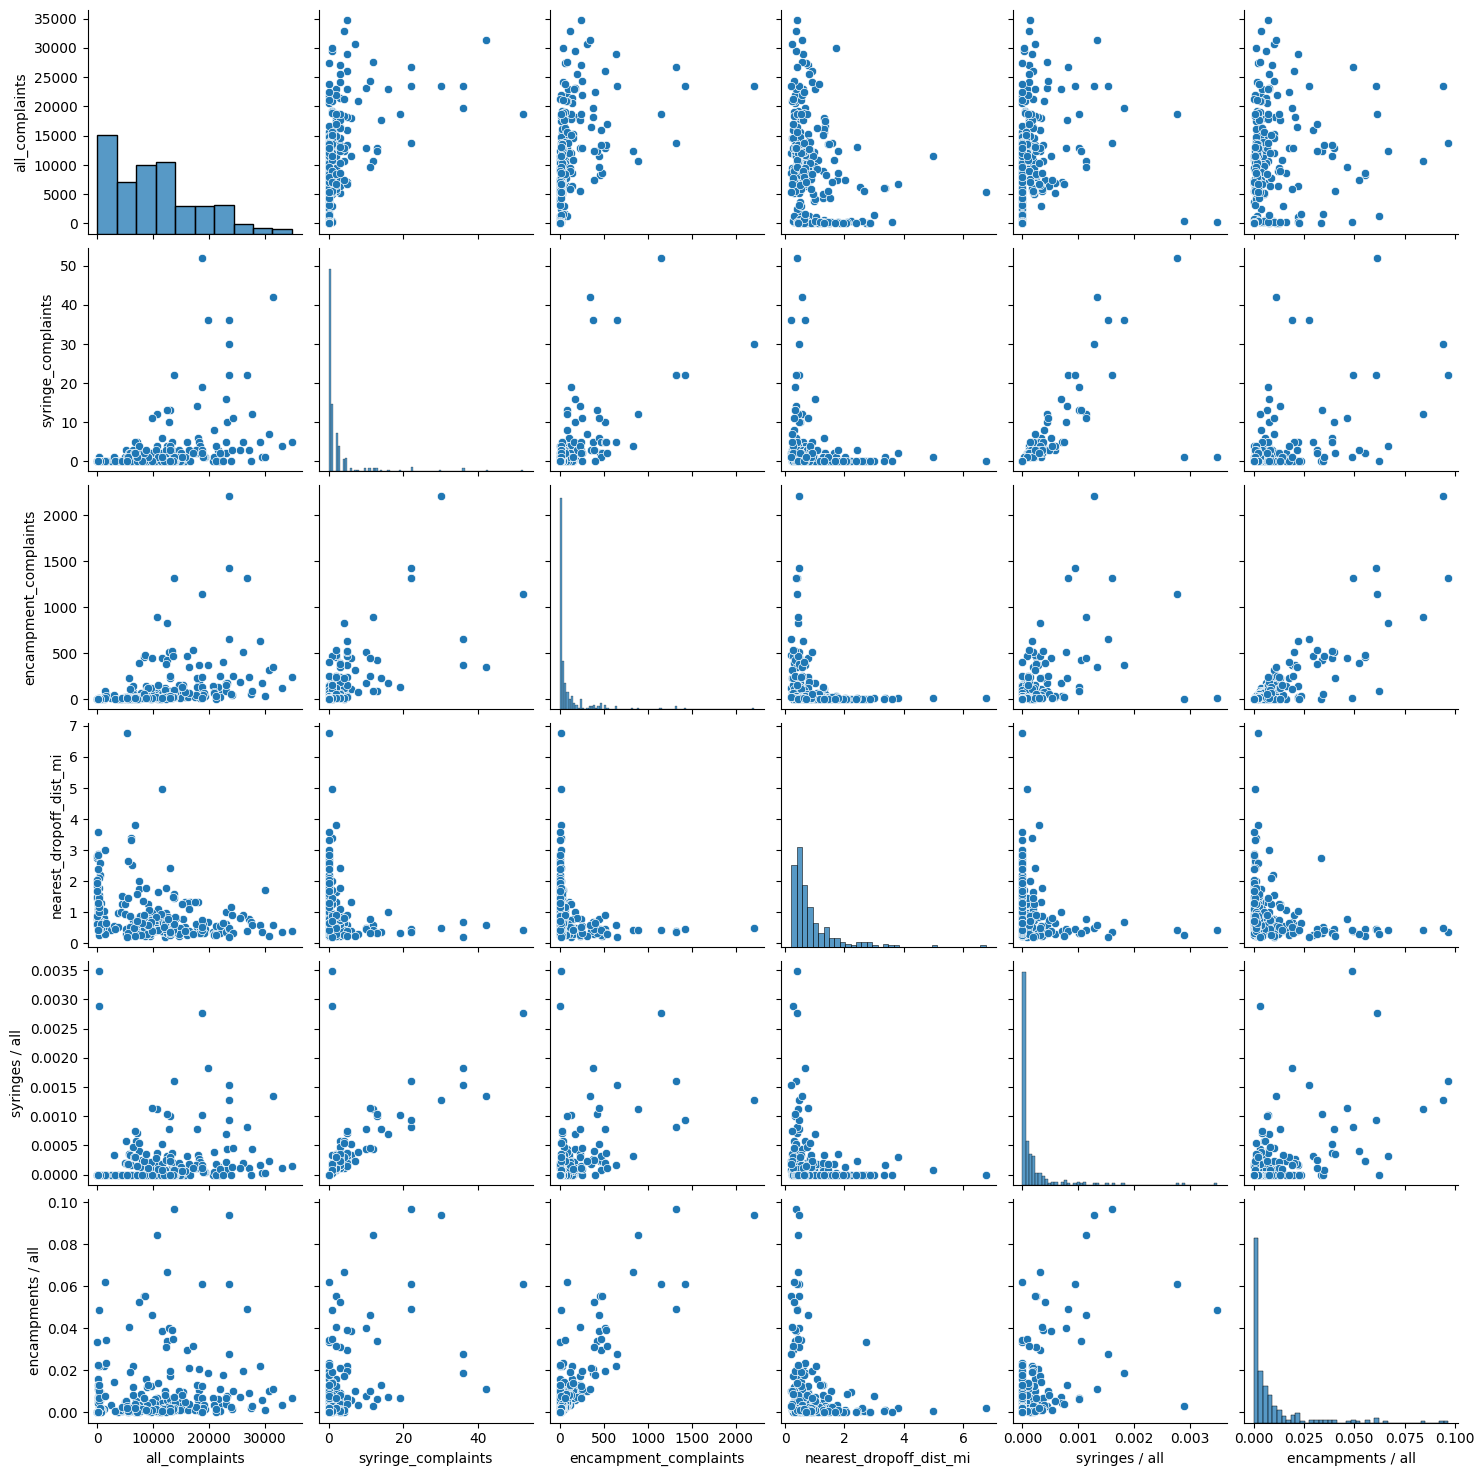

In [ ]:
# Make a pair plot with syringe complaints, dropoff_count_mile_radius, and nearest_dropoff_dist_ft
sns.pairplot(data = complaints_nta)

In [ ]:
complaints_nta.columns

Index(['NTA2020', 'all_complaints', 'syringe_complaints',
       'encampment_complaints', 'nearest_dropoff_dist_mi', 'syringes / all',
       'encampments / all'],
      dtype='object')

In [ ]:
# View the correlation matrix
complaints_nta[['syringes / all', 'encampments / all', 'nearest_dropoff_dist_mi']].corr()

,syringes / all,encampments / all,nearest_dropoff_dist_mi
syringes / all,1.000000,0.511472,-0.175902
encampments / all,0.511472,1.000000,-0.213560
nearest_dropoff_dist_mi,-0.175902,-0.213560,1.000000


We would expect to see a correlation between syringe complaints and the distance to the nearest sharps dropoff site. However, that does not really appear to be the case. There are several possible explanations for this:
* We need to normalize the complaints data differently, e.g., complaints per capita.
*   We are not taking into account the opening hours of the dropoff sites, so nta_dropoff_dist_ft is not a real measure of sharps dropoff site availability. Similarly, there could be other barriers preventing people from going to dropoff sites even if they are nearby and open.
*   Syringe complaints are not a great measure of the amount of syringe litter, but rather a measure of how bothered people are about it. Therefore, the number of 311 complaints might correlate more with something like wealth inequality.



In [ ]:
# Load the ACS data
!wget https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/population/american-community-survey/5-yr-ACS-2022.zip -O acs.zip
!unzip acs.zip

--2025-04-15 03:30:10--  https://s-media.nyc.gov/agencies/dcp/assets/files/zip/data-tools/population/american-community-survey/5-yr-ACS-2022.zip
Resolving s-media.nyc.gov (s-media.nyc.gov)... 23.5.2.160, 2600:1409:3c00:b83::1500, 2600:1409:3c00:b87::1500
Connecting to s-media.nyc.gov (s-media.nyc.gov)|23.5.2.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9389208 (9.0M) [application/zip]
Saving to: ‘acs.zip’

acs.zip             100%[===================>]   8.95M  15.5MB/s    in 0.6s    

2025-04-15 03:30:12 (15.5 MB/s) - ‘acs.zip’ saved [9389208/9389208]

Archive:  acs.zip
   creating: 5-yr ACS 2022/CityCouncilDistrict/
   creating: 5-yr ACS 2022/CityCouncilDistrict/Demographic/
  inflating: 5-yr ACS 2022/CityCouncilDistrict/Demographic/Dem_1822_CCD.xlsx  
   creating: 5-yr ACS 2022/CityCouncilDistrict/Economic/
  inflating: 5-yr ACS 2022/CityCouncilDistrict/Economic/Econ_1822_CCD.xlsx  
   creating: 5-yr ACS 2022/CityCouncilDistrict/Housing/
  inflating:

In [ ]:
# Load the ACS demographic data for NTAs
acs_demographic = pd.read_excel('/content/5-yr ACS 2022/Neighborhood-NTA/Demographic/Dem_1822_NTA.xlsx')
acs_demographic.head(2)

,GeoType,NTAType,GeogName,GeoID,Borough,Pop_1E,Pop_1M,Pop_1C,Pop_1P,Pop_1Z,...,AsnOAsnE,AsnOAsnM,AsnOAsnC,AsnOAsnP,AsnOAsnZ,Asn2plE,Asn2plM,Asn2plC,Asn2plP,Asn2plZ
0,NTA2020,0,Greenpoint,BK0101,Brooklyn,38260,1664.0,2.6,100.0,0.0,...,9,13.0,87.8,0.5,0.7,143,114.0,48.5,7.5,5.8
1,NTA2020,0,Williamsburg,BK0102,Brooklyn,64311,2670.0,2.5,100.0,0.0,...,30,43.0,87.1,0.6,0.8,190,137.0,43.9,3.6,2.5


In [ ]:
# Rename 'GeoID' to 'NTA2020'
acs_demographic = acs_demographic.rename(columns = {'GeoID': 'NTA2020'})

In [ ]:
# Keep just the Pop_1E column, which represents the population estimate for each NTA
acs_demographic_subset = acs_demographic[['NTA2020', 'Pop_1E']]

In [ ]:
# Join complaints_nta and acs_demographic_subset
complaints_nta = complaints_nta.merge(acs_demographic_subset, on = 'NTA2020')

In [ ]:
# Get the number of all complaints, syringe complaints, and encampment complaints per capita
# Note: added 1 to population to avoid infinite complaints per capita
complaints_nta['all_complaints_per_capita'] = complaints_nta['all_complaints'] / (complaints_nta['Pop_1E'] + 1)
complaints_nta['syringe_complaints_per_capita'] = complaints_nta['syringe_complaints'] / (complaints_nta['Pop_1E'] + 1)
complaints_nta['encampment_complaints_per_capita'] = complaints_nta['encampment_complaints'] / (complaints_nta['Pop_1E'] + 1)

I would like to test whether syringe complaints are driven by wealth inequality. Therefore, I will focus on the following variables from the ACS datasets:

From the Economic data:
* CvLFUEm1P: the percent of the labor force that is unemployed
* MnHHIncE: the mean household income
* PvU50P: the percent of the population with a ratio of income to poverty level < 0.5
* Pv500plP: the percent of the population with a ratio of income to poverty level > 5.00


In [ ]:
# Load the ACS economic data for NTAs
acs_economic = pd.read_excel('/content/5-yr ACS 2022/Neighborhood-NTA/Economic/Econ_1822_NTA.xlsx')
acs_economic.head(2)

,GeoType,NTAType,GeogName,GeoID,Borough,Pop16plE,Pop16plM,Pop16plC,Pop16plP,Pop16plZ,...,Pv400t499E,Pv400t499M,Pv400t499C,Pv400t499P,Pv400t499Z,Pv500plE,Pv500plM,Pv500plC,Pv500plP,Pv500plZ
0,NTA2020,0,Greenpoint,BK0101,Brooklyn,33601,1431.0,2.6,100.0,0.0,...,4404,592.0,8.2,11.6,1.5,20096,1295.0,3.9,52.8,2.5
1,NTA2020,0,Williamsburg,BK0102,Brooklyn,53760,2115.0,2.4,100.0,0.0,...,4381,656.0,9.1,6.8,1.0,29900,1629.0,3.3,46.6,1.6


In [ ]:
# Rename 'GeoID' to 'NTA2020'
acs_economic = acs_economic.rename(columns = {'GeoID': 'NTA2020'})

In [ ]:
# Keep only the columns that we'll use in the model
acs_economic = acs_economic[['NTA2020', 'CvLFUEm1P', 'MnHHIncE', 'PvU50P', 'Pv500plP']]

In [ ]:
# Join complaints_nta and acs_economic
complaints_nta = complaints_nta.merge(acs_economic, on = 'NTA2020')

I would also like to see whether syringe complaints correlate with tourism. For lack of a better dataset, I will try using the number of hotels as a measure of tourism.

In [ ]:
# Load the hotel data
hotels = pd.read_csv('https://data.cityofnewyork.us/resource/tjus-cn27.csv?$limit=5000')
hotels.head(2)

,parid,borocode,block,lot,taxyear,street_num,street_name,postcode,bldg_class,taxclass,...,borough,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,nta_code2
0,1000080039,1,8,39,2021,32,PEARL STREET,10004,H3,4,...,MANHATTAN,40.703235,-74.012421,101.0,1.0,9.0,1078968.0,1.000080e+09,Battery Park City-Lower Manhattan,NaN
1,1000080051,1,8,51,2021,6,WATER STREET,10004,H2,4,...,MANHATTAN,40.702744,-74.012201,101.0,1.0,9.0,1090472.0,1.000080e+09,Battery Park City-Lower Manhattan,NaN


In [ ]:
# Keep only the relevant columns
hotels = hotels[['parid', 'latitude', 'longitude']]

In [ ]:
# Keep only the rows with latitude and longitude data
hotels = hotels[(pd.isna(hotels['longitude']) == False) & (pd.isna(hotels['latitude']) == False)]

In [ ]:
# Turn hotels into a GeoDataFrame
hotels = gpd.GeoDataFrame(hotels, geometry = gpd.points_from_xy(hotels['longitude'], hotels['latitude']), crs = 'EPSG:4326')
hotels = hotels.to_crs(epsg=2263)

In [ ]:
# Join hotels with nta and then group by NTA2020 to find the number of hotels in each NTA
hotels = gpd.sjoin(hotels, nta[['NTA2020', 'geometry', 'Shape_Area']], how = 'left')
hotels_nta = hotels.groupby('NTA2020').agg(hotel_count = ('parid', 'count'),
                                           nta_area = ('Shape_Area', 'mean')).reset_index()

In [ ]:
# Calculate the hotels per square mile
# Note that nta_area is in square feet
hotels_nta['hotels_per_sq_mile'] = hotels_nta['hotel_count'] / (hotels_nta['nta_area'] / 27878400)

In [ ]:
# Join hotels_nta with complaints_nta
complaints_nta = complaints_nta.merge(hotels_nta[['NTA2020', 'hotels_per_sq_mile']], on = 'NTA2020')

In [ ]:
complaints_nta.columns

Index(['NTA2020', 'all_complaints', 'syringe_complaints',
       'encampment_complaints', 'nearest_dropoff_dist_mi', 'syringes / all',
       'encampments / all', 'Pop_1E', 'all_complaints_per_capita',
       'syringe_complaints_per_capita', 'encampment_complaints_per_capita',
       'CvLFUEm1P', 'MnHHIncE', 'PvU50P', 'Pv500plP', 'hotels_per_sq_mile'],
      dtype='object')

In [ ]:
complaints_nta.head()

,NTA2020,all_complaints,syringe_complaints,encampment_complaints,nearest_dropoff_dist_mi,syringes / all,encampments / all,Pop_1E,all_complaints_per_capita,syringe_complaints_per_capita,encampment_complaints_per_capita,CvLFUEm1P,MnHHIncE,PvU50P,Pv500plP,hotels_per_sq_mile
0,BK0101,17959,6,104,1.317496,0.000334,0.005791,38260,0.469381,0.000157,0.002718,5.8,152849.0,4.1,52.8,4.735612
1,BK0102,22924,16,172,1.003123,0.000698,0.007503,64311,0.356450,0.000249,0.002674,5.1,182233.0,7.1,46.6,15.458846
2,BK0103,5166,3,27,0.293892,0.000581,0.005226,46364,0.111420,0.000065,0.000582,4.7,65450.0,15.4,8.7,1.833025
3,BK0104,19718,36,374,0.669455,0.001826,0.018967,52600,0.374860,0.000684,0.007110,4.4,105681.0,12.0,29.7,3.733661
4,BK0201,6465,0,78,0.384064,0.000000,0.012065,25277,0.255756,0.000000,0.003086,2.7,269862.0,2.1,75.1,16.756663


In [ ]:
# Split the data into training and test sets
X = complaints_nta[['all_complaints', 'encampment_complaints', 'nta_dropoff_dist_ft', 'CvLFUEm1P', 'MnHHIncE', 'PvU50P', 'Pv500plP', 'hotels_per_sq_mile']]
y = complaints_nta[['syringe_complaints']]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=212)

In [ ]:
# Initialize and fit a linear regression model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

Mean Squared Error: 9.066824091175679
R2: -0.4754642145276209


This model is clearly pretty bad, given the negative R2 value!

In [ ]:
# Test whether regularization produces a better model
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression

model = ElasticNet(alpha = 0.5, l1_ratio = 0.5)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('R2:', metrics.r2_score(y_test, y_pred))

Mean Squared Error: 9.260524265111432
R2: -0.5069854696127543


Amanda's notes: add some other variables to the model!